In [48]:
import os 
import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x) 

import missingno as msno
# import matplotlib.pyplot as plt
# import seaborn as sns 
# import warnings
# warnings.filterwarnings("ignore")
from patsy import dmatrices
import statsmodels.api as sm

In [2]:
os.chdir('C:\\Users\\rhian\\Downloads\\CYPLAN 255\\AP-Exams\\Data')
ap = pd.read_csv('ap_model.csv')
ap

,year,ncessch,enrollment,AP_oneormore_relative,teachers_per_student,security_gaurds_per_students,avg_teacher_salary,%Asian,%Black,%Hispanic,%Indigenous \nAmerican,%Multiracial,%Pacific \nIslander,%White,%Female,%Male,enrl_AP,enrl_AP_science,enrl_AP_math,enrl_AP_other,enrl_gifted_talented,students_SAT_ACT,students_chronically_absent,students_report_harass_dis,students_susp_in_sch,students_susp_out_sch_single,students_susp_out_sch_multiple,students_arrested
0,2011,60000103278.0000,83.0000,-0.2329,0.0002,0.0000,17499.4056,0.0039,-0.0045,-0.0388,-0.0029,-0.0694,0.0004,0.1114,-0.0093,0.0093,0.0855,0.0317,-0.0140,-0.0548,0.0587,-0.0187,-0.0059,0.0000,-0.0108,0.0157,0.0311,0.0000
1,2011,60000310347.0000,22.2500,-0.2826,-0.0017,-0.0026,3164.3876,-0.0238,0.0080,-0.0452,0.0032,-0.0157,0.0031,0.0705,-0.0005,0.0005,0.0030,-0.0052,0.0095,0.0001,-0.0094,-0.0365,0.0140,0.0006,0.0043,0.0178,0.0234,0.0000
2,2011,60001302405.0000,-92.2500,3.6447,0.0004,-0.0003,-15597.9657,-0.0300,-0.0034,0.0053,0.0009,0.0037,0.0171,0.0063,0.0130,-0.0130,-0.0178,-0.0274,0.0175,0.0038,0.0027,0.0086,-0.0016,0.0000,0.0695,-0.0081,0.0381,0.0000
3,2011,60001311010.0000,-88.2500,1.7782,0.0011,-0.0003,-8989.7469,-0.0413,0.0013,-0.0035,0.0010,-0.0126,0.0266,0.0285,0.0102,-0.0102,-0.0043,-0.0070,-0.0213,-0.0355,-0.0092,0.0114,-0.0059,0.0000,0.0014,0.0137,0.0020,0.0008
4,2011,60001609086.0000,128.0000,-2.5556,0.0001,0.0003,1794.2415,-0.0155,-0.0074,-0.0499,0.0000,0.0033,0.0135,0.0561,-0.0004,0.0004,0.0027,-0.0110,0.0096,-0.0161,-0.0122,-0.0257,-0.0262,0.0000,-0.0046,0.0077,0.0019,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4456,2017,69113511047.0000,-162.0000,0.9247,-0.0059,-0.0008,17302.0010,-0.0020,-0.0268,0.1479,0.0000,-0.1070,-0.0034,-0.0087,-0.0024,0.0024,0.0293,-0.1378,-0.1205,0.0594,-0.0192,0.1071,-0.0452,0.0000,-0.0878,0.0117,-0.0353,-0.0011
4457,2017,69113512749.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4458,2017,69113513992.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4459,2017,69113603761.0000,-1.3333,-1.0904,0.0002,0.0000,-10080.8001,0.0001,0.0000,0.0333,-0.0018,-0.0139,0.0000,-0.0140,-0.0330,0.0330,0.0216,0.0028,-0.0045,0.0058,0.0060,0.0058,-0.0044,-0.0018,0.0000,-0.0232,0.0205,0.0000


In [3]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

In [4]:
from sklearn.metrics import mean_squared_error as mse

In [5]:
def compute_rmse(predictions, yvalues): 
    rmse = np.sqrt(np.sum(np.subtract(yvalues, predictions)**2)/len(yvalues))
    return rmse 

In [9]:
rmse_list = []
best_features = []

ap_dropped = ap.drop(['ncessch', 'AP_oneormore_relative'], axis=1)
X = np.array(ap_dropped).reshape(4461, 26)
X_columns = ap_dropped.columns
y = np.array(ap.AP_oneormore_relative)
lr = LinearRegression()

for i in range(1, 26):
    sfs = SequentialFeatureSelector(lr, n_features_to_select=i, 
                                    direction='backward', scoring='neg_mean_squared_error', 
                                    cv = 5)
    sfs.fit(X, y)

    best_cols = sfs.get_support()
    best_cols = [i for i, x in enumerate(best_cols) if x]
    best_cols = X_columns[best_cols].tolist()
    best_features.append(best_cols)

    X_subset = np.array(ap[best_cols]).reshape(4461, len(best_cols))
    lr.fit(X_subset, y)
    yhat = lr.predict(X_subset)
    rmse = compute_rmse(y, yhat)
    rmse_list.append(rmse)

score_board = pd.DataFrame(rmse_list, columns=['rmse'])
score_board.insert(0, 'n_features_to_select', range(1, 26))
score_board.insert(1, 'best_features', best_features)
score_board

KeyboardInterrupt: 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(score_board['n_features_to_select'], score_board['rmse'], 
        label='Train', color = 'blue', marker = 'o')
ax.set_xlabel('Number of Features In')
ax.set_ylabel('RMSE')
ax.set_title('RMSE vs Number of Features')
ax.legend(loc='best')
plt.show()

# do it with training and testing now!

In [10]:
from sklearn.model_selection import KFold

In [11]:
ap_dropped = ap.drop(['ncessch', 'AP_oneormore_relative'], axis=1)
X = np.array(ap_dropped).reshape(4461, 26)
X_columns = ap_dropped.columns
y = np.array(ap.AP_oneormore_relative)

kf = KFold(n_splits=5, random_state=0, shuffle=True)
for train_index, test_index in kf.split(ap_dropped):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [13]:
train_rmse_list = []
test_rmse_list = []
best_features = []
lr = LinearRegression()

for i in range(1, 26):
    sfs = SequentialFeatureSelector(lr, n_features_to_select=i, 
                                    direction='backward', scoring='neg_mean_squared_error', 
                                    cv = 5)
    sfs.fit(X_train, y_train)

    best_cols = sfs.get_support()
    best_cols = [i for i, x in enumerate(best_cols) if x]
    best_cols = X_columns[best_cols].tolist()
    best_features.append(best_cols)

    X_subset = np.array(ap_dropped[best_cols]).reshape(4461, len(best_cols))
    X_subtrain = X_subset[train_index] 
    X_subtest = X_subset[test_index]
    
    lr.fit(X_subtrain, y_train)
    yhat_train = lr.predict(X_subtrain)
    train_rmse = compute_rmse(y_train, yhat_train)
    train_rmse_list.append(train_rmse)
    
    yhat_test = lr.predict(X_subtest)
    test_rmse = compute_rmse(y_test, yhat_test)
    test_rmse_list.append(test_rmse)

best_features_forwards = best_features.copy() 
score_board = pd.DataFrame(train_rmse_list, columns=['train_rmse'])
score_board['test_rmse'] = test_rmse_list
score_board.insert(0, 'n_features_to_select', range(1, 26))
score_board.insert(1, 'best_features', best_features)
score_board

,n_features_to_select,best_features,train_rmse,test_rmse
0,1,[enrl_AP],4.1103,4.3199
1,2,"[year, enrl_AP]",4.0815,4.3091
2,3,"[year, %Hispanic, enrl_AP]",4.0770,4.2937
3,4,"[year, %Hispanic, %Multiracial, enrl_AP]",4.0645,4.2323
4,5,"[year, %Hispanic, %Indigenous \nAmerican , %Mu...",4.0586,4.2259
5,6,"[year, %Hispanic, %Indigenous \nAmerican , %Mu...",4.0556,4.2148
6,7,"[year, %Black, %Hispanic, %Indigenous \nAmeric...",4.0528,4.2106
7,8,"[year, %Black, %Hispanic, %Indigenous \nAmeric...",4.0509,4.2063
8,9,"[year, %Black, %Hispanic, %Indigenous \nAmeric...",4.0466,4.2246
9,10,"[year, %Black, %Hispanic, %Indigenous \nAmeric...",4.0304,4.1993


In [15]:
import matplotlib.pyplot as plt 

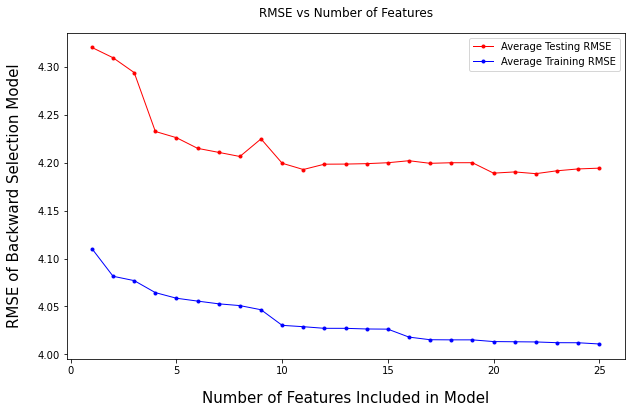

In [19]:
plt.figure(figsize=(10,6))
plt.plot(score_board['n_features_to_select'], score_board['test_rmse'], color="red", label="Average Testing RMSE", linewidth=1, marker='.')
plt.plot(score_board['n_features_to_select'], score_board['train_rmse'], color="blue", label="Average Training RMSE", linewidth=1, marker='.')
# plt.plot(optim_Lambda, best_test_rmse, marker='o', color='goldenrod', alpha=0.4, markersize = 15)
# plt.text(optim_Lambda, best_test_rmse-.04, 'Optimal Lambda: {:.4f}'.format(Lambda[14]), 
#          color='goldenrod')
plt.title("RMSE vs Number of Features", y=1.03)
plt.xlabel("Number of Features Included in Model", fontsize=15, labelpad=15)
plt.ylabel("RMSE of Backward Selection Model", fontsize=15, labelpad=15)
plt.legend()
plt.show()  

In [42]:
ap.columns = ['year', 'ncessch', 'enrollment', 'AP_oneormore_relative',
       'teachers_per_student', 'security_gaurds_per_students',
       'avg_teacher_salary', 'Pct_Asian', 'Pct_Black', 'Pct_Hispanic',
       'Pct_Indigenous_American', 'Pct_Multiracial', 'Pct_Pacific_Islander',
       'Pct_White', 'Pct_Female', 'Pct_Male', 'enrl_AP', 'enrl_AP_science',
       'enrl_AP_math', 'enrl_AP_other', 'enrl_gifted_talented',
       'students_SAT_ACT', 'students_chronically_absent',
       'students_report_harass_dis', 'students_susp_in_sch',
       'students_susp_out_sch_single', 'students_susp_out_sch_multiple',
       'students_arrested']

In [18]:
from patsy import dmatrices
import statsmodels.api as sm

In [46]:
for i in score_board[score_board['n_features_to_select']==8]['best_features']: 
    print(i)

['year', '%Black', '%Hispanic', '%Indigenous \nAmerican ', '%Multiracial', '%White', 'enrl_AP', 'students_chronically_absent']


In [47]:
### MANUALLY CHOSEN FEATURES ### 
y, X = dmatrices("AP_oneormore_relative ~ year + Pct_Black + Pct_Hispanic + Pct_Indigenous_American + Pct_Multiracial +\
                 Pct_White + enrl_AP + students_chronically_absent", data=ap, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = y
print(res.summary())

                              OLS Regression Results                             
Dep. Variable:     AP_oneormore_relative   R-squared:                       0.353
Model:                               OLS   Adj. R-squared:                  0.352
Method:                    Least Squares   F-statistic:                     303.7
Date:                   Sat, 30 Apr 2022   Prob (F-statistic):               0.00
Time:                           19:11:12   Log-Likelihood:                -12603.
No. Observations:                   4461   AIC:                         2.522e+04
Df Residuals:                       4452   BIC:                         2.528e+04
Df Model:                              8                                         
Covariance Type:               nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

In [50]:
y, X = dmatrices("AP_oneormore_relative ~ year + teachers_per_student + Pct_Asian + Pct_Multiracial + \
                 Pct_Female + enrl_AP + enrl_gifted_talented + students_SAT_ACT + students_chronically_absent + \
                 students_susp_in_sch", 
                 data=ap, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = y
print(res.summary())

                              OLS Regression Results                             
Dep. Variable:     AP_oneormore_relative   R-squared:                       0.356
Model:                               OLS   Adj. R-squared:                  0.355
Method:                    Least Squares   F-statistic:                     246.2
Date:                   Sat, 30 Apr 2022   Prob (F-statistic):               0.00
Time:                           19:26:18   Log-Likelihood:                -12592.
No. Observations:                   4461   AIC:                         2.521e+04
Df Residuals:                       4450   BIC:                         2.528e+04
Df Model:                             10                                         
Covariance Type:               nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

In [174]:
best_features_forwards[10]

['year',
 'teachers_per_student',
 '%Asian',
 '%Hispanic',
 '%Multiracial',
 '%Female',
 'enrl_AP',
 'enrl_gifted_talented',
 'students_SAT_ACT',
 'students_chronically_absent',
 'students_susp_in_sch']

In [171]:
score_board[10:11]

,n_features_to_select,best_features,train_rmse,test_rmse
10,11,"[year, teachers_per_student, %Asian, %Hispanic...",4.0309,4.2136


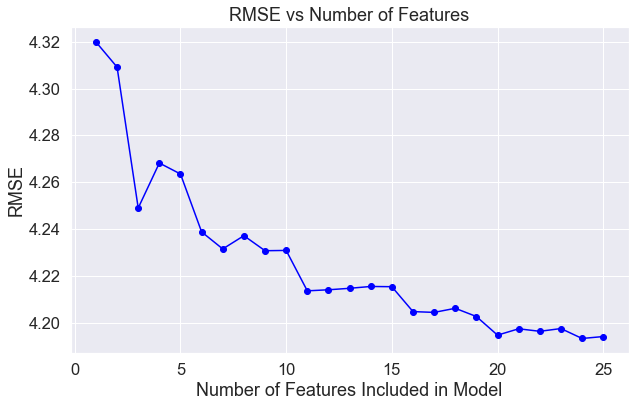

In [169]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.plot(score_board['n_features_to_select'], score_board['test_rmse'], 
        color = 'blue', marker = 'o')
ax.set_xlabel('Number of Features Included in Model')
ax.set_ylabel('RMSE')
ax.set_title('RMSE vs Number of Features')
plt.show()

In [ ]:
best_features_forwards[10] = 

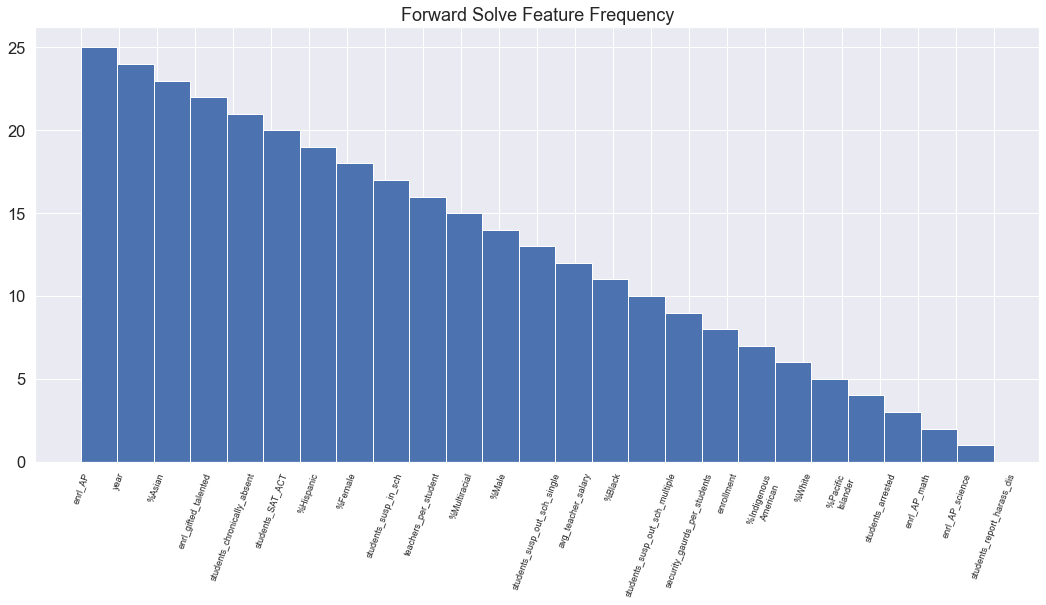

In [142]:
plt.figure(figsize=(18,8))
plt.hist(sum(best_features_forwards, []), 25)
plt.title('Forward Solve Feature Frequency')
plt.xticks(fontsize=9, rotation=70);

In [ ]:
### MANUALLY CHOSEN FEATURES ### 
y, X = dmatrices("Cruder_Rate ~ Year + WA_MALE + Urbanicity + Unemployment_rate + \
Dispense_rate + Incarceration_Rate_per_100k + PovertyPercentage + MedianHHI", 
                 data=stzd_geogon15, return_type='dataframe')
mod = sm.OLS(np.log(y), X, cov_type = 'HC3')
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = y
print(res.summary())

# Backwards solve 

In [143]:
rmse_list = []
best_features = []
lr = LinearRegression()

for i in range(1, 26):
    sfs = SequentialFeatureSelector(lr, n_features_to_select=i, 
                                    direction='backward', scoring='neg_mean_squared_error', 
                                    cv = 5)
    sfs.fit(X_train, y_train)

    best_cols = sfs.get_support()
    best_cols = [i for i, x in enumerate(best_cols) if x]
    best_cols = X_columns[best_cols].tolist()
    best_features.append(best_cols)

    X_subset = np.array(ap_dropped[best_cols]).reshape(4461, len(best_cols))
    X_subtrain = X_subset[train_index] 
    X_subtest = X_subset[test_index]
    lr.fit(X_subtrain, y_train)
    yhat_test = lr.predict(X_subtest)
    rmse = compute_rmse(y_test, yhat_test)
    rmse_list.append(rmse)

best_features_backwards = best_features.copy()
score_board = pd.DataFrame(rmse_list, columns=['rmse'])
score_board.insert(0, 'n_features_to_select', range(1, 26))
score_board.insert(1, 'best_features', best_features)
score_backward = score_board.copy()
score_backward

,n_features_to_select,best_features,rmse
0,1,[enrl_AP],4.3199
1,2,"[year, enrl_AP]",4.3091
2,3,"[year, %Hispanic, enrl_AP]",4.2937
3,4,"[year, %Hispanic, %Multiracial, enrl_AP]",4.2323
4,5,"[year, %Hispanic, %Indigenous \nAmerican , %Mu...",4.2259
5,6,"[year, %Hispanic, %Indigenous \nAmerican , %Mu...",4.2148
6,7,"[year, %Black, %Hispanic, %Indigenous \nAmeric...",4.2106
7,8,"[year, %Black, %Hispanic, %Indigenous \nAmeric...",4.2063
8,9,"[year, %Black, %Hispanic, %Indigenous \nAmeric...",4.2246
9,10,"[year, %Black, %Hispanic, %Indigenous \nAmeric...",4.1993


In [ ]:
best_features_backwa

NameError: name 'score_backward' is not defined

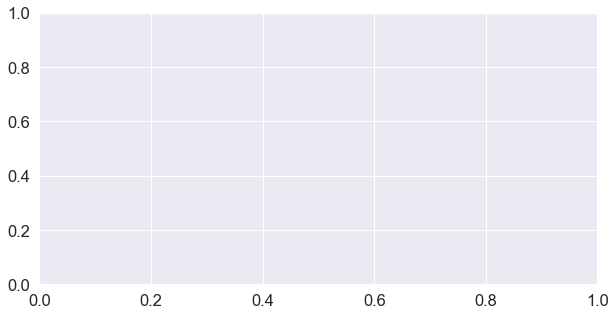

In [164]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(score_backward['n_features_to_select'], score_backward['rmse'], 
        color = 'blue', marker = 'o')
ax.set_xlabel('Number of Features Included in Model')
ax.set_ylabel('RMSE')
ax.set_title('Backwards Solve: RMSE vs Number of Features')
plt.show()

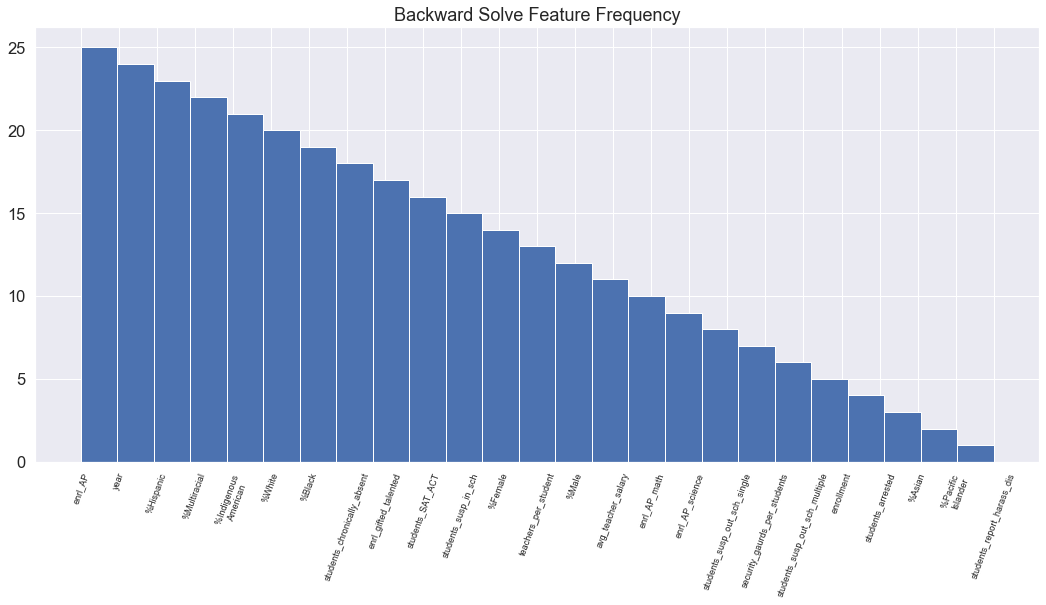

In [146]:
plt.figure(figsize=(18,8))
plt.hist(sum(best_features, []), 25)
plt.title('Backward Solve Feature Frequency')
plt.xticks(fontsize=9, rotation=70);

# Do it without enrl_AP!

In [148]:
ap_dropped

,year,enrollment,teachers_per_student,security_gaurds_per_students,avg_teacher_salary,%Asian,%Black,%Hispanic,%Indigenous \nAmerican,%Multiracial,%Pacific \nIslander,%White,%Female,%Male,enrl_AP,enrl_AP_science,enrl_AP_math,enrl_AP_other,enrl_gifted_talented,students_SAT_ACT,students_chronically_absent,students_report_harass_dis,students_susp_in_sch,students_susp_out_sch_single,students_susp_out_sch_multiple,students_arrested
0,2011,83.0000,0.0002,0.0000,17499.4056,0.0039,-0.0045,-0.0388,-0.0029,-0.0694,0.0004,0.1114,-0.0093,0.0093,0.0855,0.0317,-0.0140,-0.0548,0.0587,-0.0187,-0.0059,0.0000,-0.0108,0.0157,0.0311,0.0000
1,2011,22.2500,-0.0017,-0.0026,3164.3876,-0.0238,0.0080,-0.0452,0.0032,-0.0157,0.0031,0.0705,-0.0005,0.0005,0.0030,-0.0052,0.0095,0.0001,-0.0094,-0.0365,0.0140,0.0006,0.0043,0.0178,0.0234,0.0000
2,2011,-92.2500,0.0004,-0.0003,-15597.9657,-0.0300,-0.0034,0.0053,0.0009,0.0037,0.0171,0.0063,0.0130,-0.0130,-0.0178,-0.0274,0.0175,0.0038,0.0027,0.0086,-0.0016,0.0000,0.0695,-0.0081,0.0381,0.0000
3,2011,-88.2500,0.0011,-0.0003,-8989.7469,-0.0413,0.0013,-0.0035,0.0010,-0.0126,0.0266,0.0285,0.0102,-0.0102,-0.0043,-0.0070,-0.0213,-0.0355,-0.0092,0.0114,-0.0059,0.0000,0.0014,0.0137,0.0020,0.0008
4,2011,128.0000,0.0001,0.0003,1794.2415,-0.0155,-0.0074,-0.0499,0.0000,0.0033,0.0135,0.0561,-0.0004,0.0004,0.0027,-0.0110,0.0096,-0.0161,-0.0122,-0.0257,-0.0262,0.0000,-0.0046,0.0077,0.0019,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4456,2017,-162.0000,-0.0059,-0.0008,17302.0010,-0.0020,-0.0268,0.1479,0.0000,-0.1070,-0.0034,-0.0087,-0.0024,0.0024,0.0293,-0.1378,-0.1205,0.0594,-0.0192,0.1071,-0.0452,0.0000,-0.0878,0.0117,-0.0353,-0.0011
4457,2017,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4458,2017,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4459,2017,-1.3333,0.0002,0.0000,-10080.8001,0.0001,0.0000,0.0333,-0.0018,-0.0139,0.0000,-0.0140,-0.0330,0.0330,0.0216,0.0028,-0.0045,0.0058,0.0060,0.0058,-0.0044,-0.0018,0.0000,-0.0232,0.0205,0.0000


In [175]:
ap_dropped = ap.drop(['ncessch', 'AP_oneormore_relative', 'enrl_AP', 'enrl_AP_science', 
                      'enrl_AP_math', 'enrl_AP_other'], axis=1)
X = np.array(ap_dropped).reshape(4461, 22)
X_columns = ap_dropped.columns
y = np.array(ap.AP_oneormore_relative)

kf = KFold(n_splits=5, random_state=0, shuffle=True)
for train_index, test_index in kf.split(ap_dropped):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [181]:
train_rmse_list = []
test_rmse_list = []
best_features = []
lr = LinearRegression()

for i in range(1, 22):
    sfs = SequentialFeatureSelector(lr, n_features_to_select=i, 
                                    direction='forward', scoring='neg_mean_squared_error', 
                                    cv = 5)
    sfs.fit(X_train, y_train)

    best_cols = sfs.get_support()
    best_cols = [i for i, x in enumerate(best_cols) if x]
    best_cols = X_columns[best_cols].tolist()
    best_features.append(best_cols)

    X_subset = np.array(ap_dropped[best_cols]).reshape(4461, len(best_cols))
    X_subtrain = X_subset[train_index] 
    X_subtest = X_subset[test_index]
    
    lr.fit(X_subtrain, y_train)
    yhat_train = lr.predict(X_subtrain)
    train_rmse = compute_rmse(y_train, yhat_train)
    train_rmse_list.append(train_rmse)
    
    yhat_test = lr.predict(X_subtest)
    test_rmse = compute_rmse(y_test, yhat_test)
    test_rmse_list.append(test_rmse)

best_features_forwards_noAP = best_features.copy() 
score_board = pd.DataFrame(train_rmse_list, columns=['train_rmse'])
score_board['test_rmse'] = test_rmse_list
score_board.insert(0, 'n_features_to_select', range(1, 22))
score_board.insert(1, 'best_features', best_features)
score_board_forwards_noAP = score_board.copy()
score_board_forwards_noAP

,n_features_to_select,best_features,train_rmse,test_rmse
0,1,[year],4.8054,5.4003
1,2,"[year, enrl_gifted_talented]",4.7344,5.3782
2,3,"[year, enrl_gifted_talented, students_SAT_ACT]",4.6938,5.3064
3,4,"[year, %Asian, enrl_gifted_talented, students_...",4.6719,5.2378
4,5,"[year, %Asian, %Pacific \nIslander, enrl_gifte...",4.6572,5.1852
5,6,"[year, %Asian, %Pacific \nIslander, enrl_gifte...",4.6502,5.1601
6,7,"[year, %Asian, %Pacific \nIslander, enrl_gifte...",4.6447,5.1546
7,8,"[year, %Asian, %Pacific \nIslander, enrl_gifte...",4.6437,5.1549
8,9,"[year, %Asian, %Pacific \nIslander, %Female, e...",4.6403,5.1609
9,10,"[year, %Asian, %Pacific \nIslander, %Female, %...",4.6365,5.1615


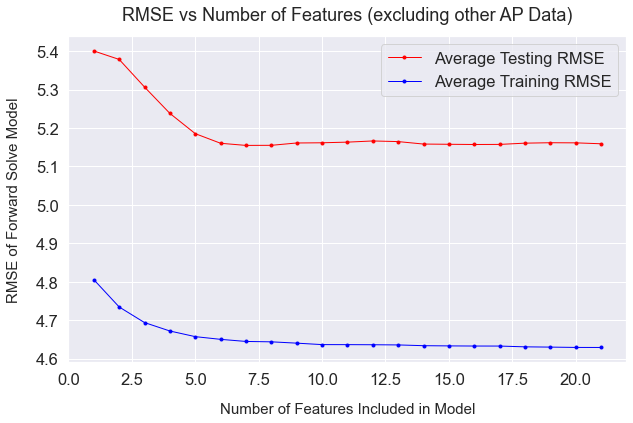

In [182]:
plt.figure(figsize=(10,6))
plt.plot(score_board['n_features_to_select'], score_board['test_rmse'], color="red", label="Average Testing RMSE", linewidth=1, marker='.')
plt.plot(score_board['n_features_to_select'], score_board['train_rmse'], color="blue", label="Average Training RMSE", linewidth=1, marker='.')
# plt.plot(optim_Lambda, best_test_rmse, marker='o', color='goldenrod', alpha=0.4, markersize = 15)
# plt.text(optim_Lambda, best_test_rmse-.04, 'Optimal Lambda: {:.4f}'.format(Lambda[14]), 
#          color='goldenrod')
plt.title("RMSE vs Number of Features (excluding other AP Data)", y=1.03)
plt.xlabel("Number of Features Included in Model", fontsize=15, labelpad=15)
plt.ylabel("RMSE of Forward Solve Model", fontsize=15, labelpad=15)
plt.legend()
plt.show()  

In [185]:
min(score_board_forwards_noAP['test_rmse'])

5.154617490754266

In [190]:
score_board_forwards_noAP['best_features'][6]

['year',
 '%Asian',
 '%Pacific \nIslander',
 'enrl_gifted_talented',
 'students_SAT_ACT',
 'students_chronically_absent',
 'students_susp_out_sch_multiple']

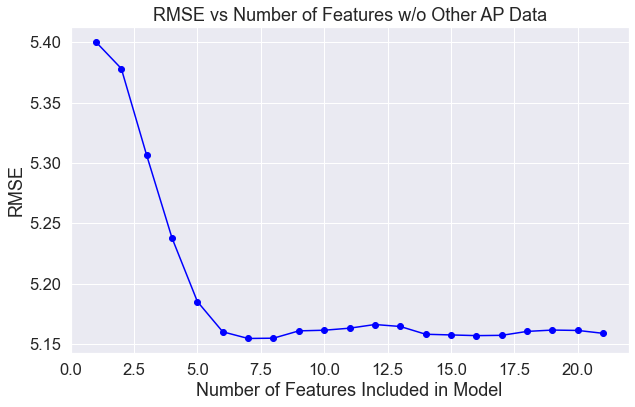

In [184]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.plot(score_board_forwards_noAP['n_features_to_select'], score_board_forwards_noAP['test_rmse'], 
        color = 'blue', marker = 'o')
ax.set_xlabel('Number of Features Included in Model')
ax.set_ylabel('RMSE')
ax.set_title('RMSE vs Number of Features w/o Other AP Data')
plt.show()

In [25]:
ap.columns

Index(['year', 'ncessch', 'enrollment', 'AP_oneormore_relative',
       'teachers_per_student', 'security_gaurds_per_students',
       'avg_teacher_salary', 'Pct_Asian', 'Pct_Black', 'Pct_Hispanic',
       'Pct_Indigenous_American ', 'Pct_Multiracial', 'Pct_Pacific_Islander',
       'Pct_White', 'Pct_Female', 'Pct_Male', 'enrl_AP', 'enrl_AP_science',
       'enrl_AP_math', 'enrl_AP_other', 'enrl_gifted_talented',
       'students_SAT_ACT', 'students_chronically_absent',
       'students_report_harass_dis', 'students_susp_in_sch',
       'students_susp_out_sch_single', 'students_susp_out_sch_multiple',
       'students_arrested'],
      dtype='object')

In [26]:
### MANUALLY CHOSEN FEATURES ### 
y, X = dmatrices("AP_oneormore_relative ~ year + Pct_Asian + Pct_Pacific_Islander + enrl_gifted_talented +\
                 students_SAT_ACT + students_susp_out_sch_multiple + students_susp_out_sch_multiple", 
                 data=ap, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = y
print(res.summary())


                              OLS Regression Results                             
Dep. Variable:     AP_oneormore_relative   R-squared:                       0.122
Model:                               OLS   Adj. R-squared:                  0.121
Method:                    Least Squares   F-statistic:                     103.0
Date:                   Tue, 26 Apr 2022   Prob (F-statistic):          8.79e-122
Time:                           23:11:16   Log-Likelihood:                -13284.
No. Observations:                   4461   AIC:                         2.658e+04
Df Residuals:                       4454   BIC:                         2.663e+04
Df Model:                              6                                         
Covariance Type:               nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

In [176]:
rmse_list = []
best_features = []
lr = LinearRegression()

for i in range(1, 22):
    sfs = SequentialFeatureSelector(lr, n_features_to_select=i, 
                                    direction='forward', scoring='neg_mean_squared_error', 
                                    cv = 5)
    sfs.fit(X_train, y_train)

    best_cols = sfs.get_support()
    best_cols = [i for i, x in enumerate(best_cols) if x]
    best_cols = X_columns[best_cols].tolist()
    best_features.append(best_cols)

    X_subset = np.array(ap_dropped[best_cols]).reshape(4461, len(best_cols))
    X_subtrain = X_subset[train_index] 
    X_subtest = X_subset[test_index]
    lr.fit(X_subtrain, y_train)
    yhat_test = lr.predict(X_subtest)
    rmse = compute_rmse(y_test, yhat_test)
    rmse_list.append(rmse)

best_features_forwards = best
score_board = pd.DataFrame(rmse_list, columns=['rmse'])
score_board.insert(0, 'n_features_to_select', range(1, 22))
score_board.insert(1, 'best_features', best_features)
score_forward_noenrlAP = score_board.copy()
score_forward_noenrlAP

,n_features_to_select,best_features,rmse
0,1,[year],5.4003
1,2,"[year, enrl_gifted_talented]",5.3782
2,3,"[year, enrl_gifted_talented, students_SAT_ACT]",5.3064
3,4,"[year, %Asian, enrl_gifted_talented, students_...",5.2378
4,5,"[year, %Asian, %Pacific \nIslander, enrl_gifte...",5.1852
5,6,"[year, %Asian, %Pacific \nIslander, enrl_gifte...",5.1601
6,7,"[year, %Asian, %Pacific \nIslander, enrl_gifte...",5.1546
7,8,"[year, %Asian, %Pacific \nIslander, enrl_gifte...",5.1549
8,9,"[year, %Asian, %Pacific \nIslander, %Female, e...",5.1609
9,10,"[year, %Asian, %Pacific \nIslander, %Female, %...",5.1615


In [178]:
min(rmse_list)

5.154617490754266

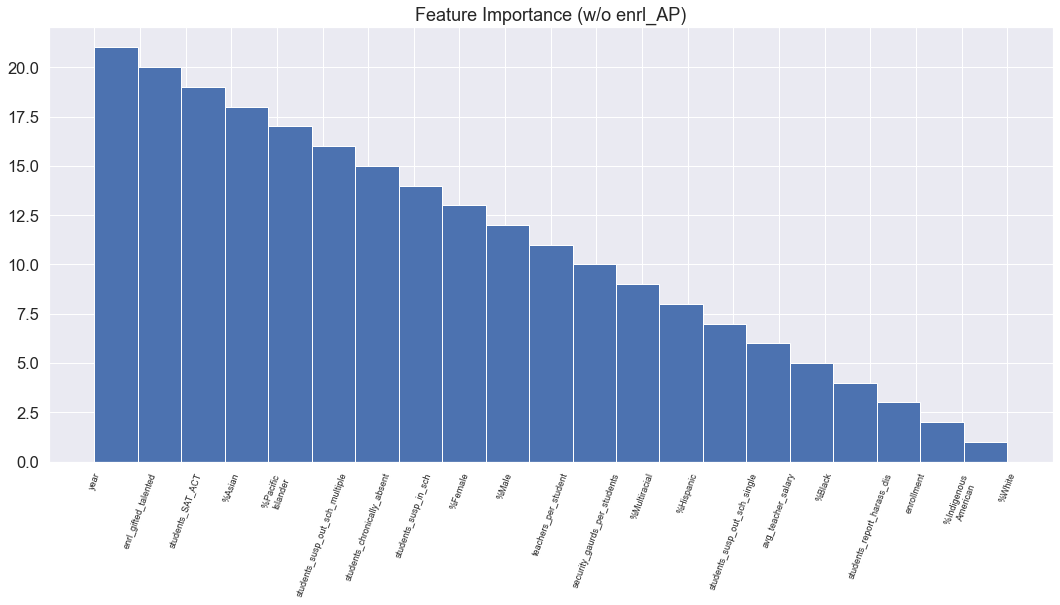

In [155]:
plt.figure(figsize=(18,8))
plt.hist(sum(best_features, []), 21)
plt.title('Feature Importance (w/o enrl_AP)')
plt.xticks(fontsize=9, rotation=70);


# More things? 

In [38]:
sort_values(by = 'mean_test_score', ascending = False)

,year,security_gaurds_per_students,%Female,enrl_AP_other,students_susp_in_sch
0,2011,0.0000,-0.0093,-0.0548,-0.0108
1,2011,-0.0026,-0.0005,0.0001,0.0043
2,2011,-0.0003,0.0130,0.0038,0.0695
3,2011,-0.0003,0.0102,-0.0355,0.0014
4,2011,0.0003,-0.0004,-0.0161,-0.0046
...,...,...,...,...,...
4456,2017,-0.0008,-0.0024,0.0594,-0.0878
4457,2017,0.0000,0.0000,0.0000,0.0000
4458,2017,0.0000,0.0000,0.0000,0.0000
4459,2017,0.0000,-0.0330,0.0058,0.0000
